In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
import matplotlib.pyplot as plt

In [3]:
from methods.DataDrivenMethods import DDMethod
from solvers.Solver import Solver
import numpy as np
from sklearn.model_selection import train_test_split
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [5]:
device

device(type='cuda')

In [6]:
nx = 101

In [7]:
params_solver = {'equation': 'Poisson', 
                 'domain': [0, 1], 
                 'D': 0.1,
                 'nx': nx,
                 'source term' : lambda x : np.ones_like(x)}

In [8]:
params_method = {'layer_dims': [2, 20, 20, 20, 1],
                 'activations': 'tanh', 
                 'device': device, 
                 'seed': 123, 
                 'method_name': 'PINN'}

In [9]:
params = {'solver' : params_solver, 'method' : params_method}
solver = Solver(params=params)

In [10]:
model = DDMethod(params=params)

In [11]:
Dmin, Dmax = 1, 10
num_D = 1000

D_list = (Dmax - Dmin)* np.random.rand(num_D, 1) + Dmin

In [12]:
U_sols = []

for d in D_list:
    solver.change_D(new_D=d)
    U_sols.append(solver.solve())

U_sols = np.stack(U_sols)

In [13]:
d_train, d_val, u_train, u_val = train_test_split(D_list, U_sols, test_size=0.2, random_state=123)

In [14]:
d_train.shape

(800, 1)

In [15]:
D_train_repeated = torch.Tensor(d_train.repeat(nx, 1).reshape(-1, 1))
D_val_repeated = torch.Tensor(d_val.repeat(nx, 1).reshape(-1, 1))

In [16]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

In [17]:
DX_train = torch.cat((D_train_repeated, X_train), dim=1)
DX_val = torch.cat((D_val_repeated, X_val), dim=1)
U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

In [18]:
DX_train.shape

torch.Size([80800, 2])

In [19]:
hyperparameters = {'lr': 1e-3, 'epochs': 10000, 'optimizer': 'Adam', 'batch_size': 80800}

In [20]:
model.fit(hyperparameters=hyperparameters, 
          DX_train=DX_train, 
          DX_val=DX_val,
          U_train=U_train, 
          U_val=U_val,
          data_ratio = 0.,
          physics_ratio = 1.)

Fitting PINN


[tr : 2.9e-06, val : 9.9e-08]: 100%|██████| 10000/10000 [02:16<00:00, 73.20it/s]

PINN fitted


In [21]:
test = model.apply_method([8.17453295])

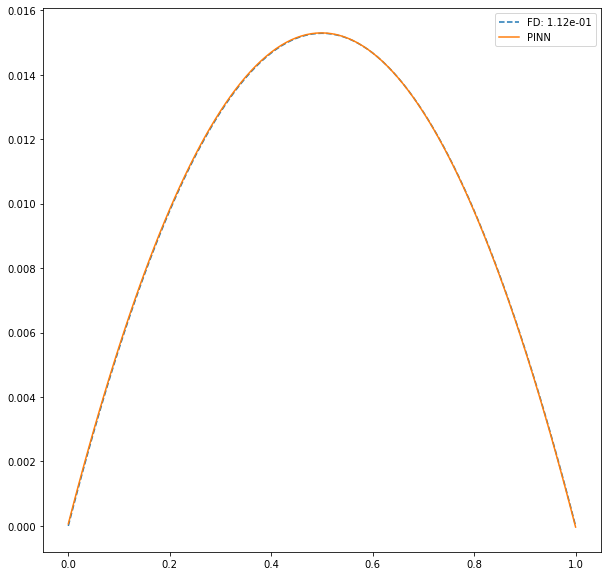

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# model

solver.change_D(new_D=8.17453295)
U_FD = solver.solve()

plt.plot(solver.x, U_FD, '--', label=f'FD: {np.linalg.norm(U_FD, 2):.2e}')
plt.plot(solver.x, test, label=f'PINN')
plt.legend()
plt.show()

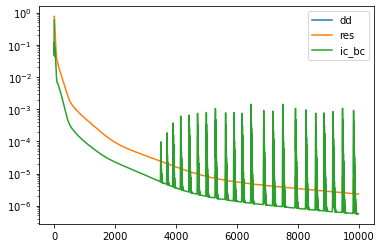

In [27]:
plt.yscale('log')

plt.plot(model._method._losses['train']['data'], label = 'dd')
plt.plot(model._method._losses['train']['residual'], label = 'res')
plt.plot(model._method._losses['train']['ic_bc'], label = 'ic_bc')

#plt.plot(model._method._losses['val'], label = 'val')

plt.legend()
plt.show()

In [37]:
d = torch.rand(3, 2)

In [38]:
len(d)

3

In [36]:
d.repeat(1, 3).view(-1, 1)

tensor([[0.1730],
        [0.1730],
        [0.1730],
        [0.3308],
        [0.3308],
        [0.3308],
        [0.9275],
        [0.9275],
        [0.9275]])

In [39]:
a = 0
b = 0.

In [40]:
a == b

True